# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 1.4 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


## Подготовка данных

In [2]:
# Подключим все необходимые библиотеки 
import os
import math
import time
import itertools 
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
from pathlib import Path
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
class DataScience:

    def path_to_files(self, path, link):
        Path('datasets').mkdir(parents=True, exist_ok=True)
        def get_file(file_name, url):
            if not os.path.exists(file_name):
                print(file_name, 'файл не найден, будет загружен из сети')
                _ = urllib.request.urlretrieve(url, file_name)
        urls = {
            'dataset': (path, link)
        }
        [get_file(*urls[k]) for k in urls]
        data = pd.read_csv(urls['dataset'][0])
        return data


    def corr_diagram(self, x):
        plt.figure(figsize=(12, 10), dpi=80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0,
                    annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def clean_dataset(self, df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)

        return df[indices_to_keep].astype(np.float64)

    def missing_zero_values_table(self, df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
            columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
        print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
                                                                                                       "There are " + str(
            mz_table.shape[0]) +
              " columns that have missing values.")

        return mz_table

       
    def fill_with_mode(self, column, column1, column2):
        df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))
        
    def rmse(self,predictions, targets): 
        return np.sqrt(((predictions - targets) ** 2).mean())

In [4]:
#Присвоим переменной ds класс DataScience
ds = DataScience()

In [5]:
#откроем файл autos.csv
df = ds.path_to_files('/datasets/autos.csv','https://code.s3.yandex.net/datasets/autos.csv')

In [6]:
#Изучим первоначальную инфмормацию о датасете методом info и describe
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
#Посмотрим на количество пустых значений в датасете
ds.missing_zero_values_table(df)

Your selected dataframe has 16 columns and 354369 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Repaired,0,71154,20.1,71154,20.1,object
VehicleType,0,37490,10.6,37490,10.6,object
FuelType,0,32895,9.3,32895,9.3,object
Gearbox,0,19833,5.6,19833,5.6,object
Model,0,19705,5.6,19705,5.6,object


In [8]:
#Посмотрим на количество дубликатов в датасете
df.duplicated().sum()

4

In [9]:
#Удалим столбцы которые нам не понадобятся
df=df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures', 'Repaired'], axis=1)
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda


In [10]:
#Немного поменяем местами столбцы, чтобы было удобно читать.
column_names = ['Brand','Model','VehicleType','RegistrationYear','Gearbox','Power','FuelType','Kilometer','RegistrationMonth','Price']
df = df.reindex(columns=column_names)

In [11]:
df.head()

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,RegistrationMonth,Price
0,volkswagen,golf,NaN,1993,manual,0,petrol,150000,0,480
1,audi,NaN,coupe,2011,manual,190,gasoline,125000,5,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,8,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,6,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,7,3600


In [12]:
#Посмотрим сколько уникальных значений мы имеем в categorical признаках
categorical = ['Brand','Model','VehicleType','Gearbox','FuelType', 'Kilometer']
numerical_features_names = df.select_dtypes(include=['int64'])
df[categorical].nunique()

Brand           40
Model          250
VehicleType      8
Gearbox          2
FuelType         7
Kilometer       13
dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


2700.0

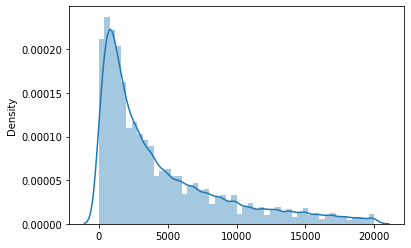

In [13]:
#Посмотрим на распределение целевого признака
sns.distplot(df.Price.values)
np.median(df.Price.values)

In [14]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [15]:
df[df['Price']==0]['Price'].count()

10772

In [16]:
percentage = df[df['Price']==0]['Price'].count() / df['Price'].count() * 100
print(f'Кажется, что эти {percentage}% можно оставить либо удалить, как как он незначителен')

Кажется, что эти 3.0397692800442475% можно оставить либо удалить, как как он незначителен


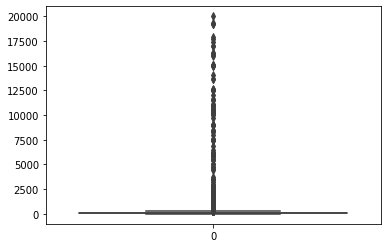

In [17]:
#Посмотрим на распределение мощности автомобилей
sns.boxplot(data=df['Power']);

<AxesSubplot:>

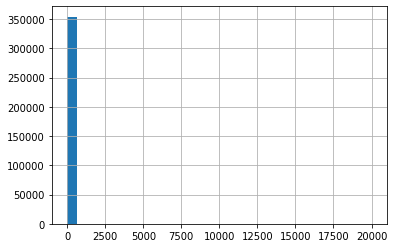

In [18]:
df['Power'].hist(bins=30)

In [19]:
df['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


105.0

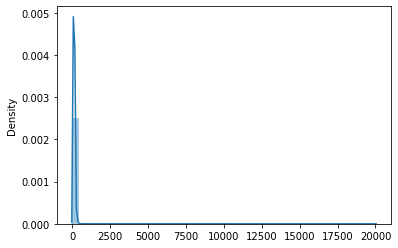

In [20]:
sns.distplot(df.Power.values)
np.median(df.Power.values)

In [21]:
df = df[df['Price']!=0]

In [22]:
df = df[df['Power']!=0]

In [23]:
df = df[df['Power']<=400] # уберем машины с мощностью больше 400 л.с., Поэтому предлагаю срезать ненужную информацию

In [24]:
df

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,RegistrationMonth,Price
1,audi,NaN,coupe,2011,manual,190,gasoline,125000,5,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,8,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,6,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,7,3600
5,bmw,3er,sedan,1995,manual,102,petrol,150000,10,650
...,...,...,...,...,...,...,...,...,...,...
354361,alfa_romeo,159,NaN,2016,auto,150,NaN,150000,12,5250
354362,seat,leon,sedan,2004,manual,225,petrol,150000,5,3200
354366,smart,fortwo,convertible,2000,auto,101,petrol,125000,3,1199
354367,volkswagen,transporter,bus,1996,manual,102,gasoline,150000,3,9200


In [25]:
#На основе имеющихся данных попробуем заменить пустые значения
ds.fill_with_mode('Model','Brand','RegistrationYear')
ds.fill_with_mode('VehicleType','Brand','Model')
ds.fill_with_mode('FuelType','Brand','Model')

In [26]:
#Заменим Empty на nan
df = df.replace('Empty',np.nan)

In [27]:
ds.missing_zero_values_table(df) 

Your selected dataframe has 10 columns and 306536 Rows.
There are 4 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Gearbox,0,6074,2.0,6074,2.0,object
Model,0,1924,0.6,1924,0.6,object
VehicleType,0,7,0.0,7,0.0,object
FuelType,0,3,0.0,3,0.0,object


**Пропущенных данных имеем ~5 % , можно и дропнуть их**

In [28]:
#Удалим nan Значения и дубликаты
df = df.dropna()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269491 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Brand              269491 non-null  object
 1   Model              269491 non-null  object
 2   VehicleType        269491 non-null  object
 3   RegistrationYear   269491 non-null  int64 
 4   Gearbox            269491 non-null  object
 5   Power              269491 non-null  int64 
 6   FuelType           269491 non-null  object
 7   Kilometer          269491 non-null  int64 
 8   RegistrationMonth  269491 non-null  int64 
 9   Price              269491 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 22.6+ MB


In [29]:
df['RegistrationYear'].describe()

count    269491.000000
mean       2003.418953
std          19.789565
min        1500.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        8200.000000
Name: RegistrationYear, dtype: float64

<AxesSubplot:xlabel='RegistrationYear'>

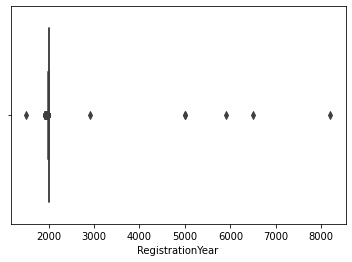

In [30]:
sns.boxplot(x=df['RegistrationYear'])

In [31]:
df[(df['RegistrationYear'] > 2022) | (df['RegistrationYear'] < 1950)]['RegistrationYear'].count()

37

In [32]:
df['Kilometer'].unique()

array([125000, 150000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000])

In [33]:
df['Kilometer'].nunique()

13

**мое упущение, данные заполняются кратно тысячам километров**

In [34]:
df.head(5)

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,RegistrationMonth,Price
1,audi,a4,coupe,2011,manual,190,gasoline,125000,5,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,8,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,6,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,7,3600
5,bmw,3er,sedan,1995,manual,102,petrol,150000,10,650


In [35]:
#Скопируем датафрейм для моделей catboost и lightgbm без перевода категориальных данных в номинальные, так как обе модели
#поддерживают работу с категориальными данными

df_with_categorical_features = df.copy()
df_with_categorical_features

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,RegistrationMonth,Price
1,audi,a4,coupe,2011,manual,190,gasoline,125000,5,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,8,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,6,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,7,3600
5,bmw,3er,sedan,1995,manual,102,petrol,150000,10,650
...,...,...,...,...,...,...,...,...,...,...
354361,alfa_romeo,159,wagon,2016,auto,150,gasoline,150000,12,5250
354362,seat,leon,sedan,2004,manual,225,petrol,150000,5,3200
354366,smart,fortwo,convertible,2000,auto,101,petrol,125000,3,1199
354367,volkswagen,transporter,bus,1996,manual,102,gasoline,150000,3,9200


In [36]:
#приведем категориальные признаки в номинальные с помощью LabelEncoder
# label_encode = LabelEncoder()
# columns_for_convert = list(df.select_dtypes(include='object').columns)
# for column in columns_for_convert:
#     label_encode.fit(df[column].astype('str'))
#     df[column] = label_encode.transform(df[column].astype('str'))

In [37]:
#Стандартизируем признаки с помощью StandardScaler
# scaler = StandardScaler()
# numeric = ['RegistrationYear','Power','Kilometer']
# scaler.fit(df[numeric])
# df[numeric] = scaler.transform(df[numeric])

In [38]:
df.head(5)

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,RegistrationMonth,Price
1,audi,a4,coupe,2011,manual,190,gasoline,125000,5,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,8,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,6,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,7,3600
5,bmw,3er,sedan,1995,manual,102,petrol,150000,10,650


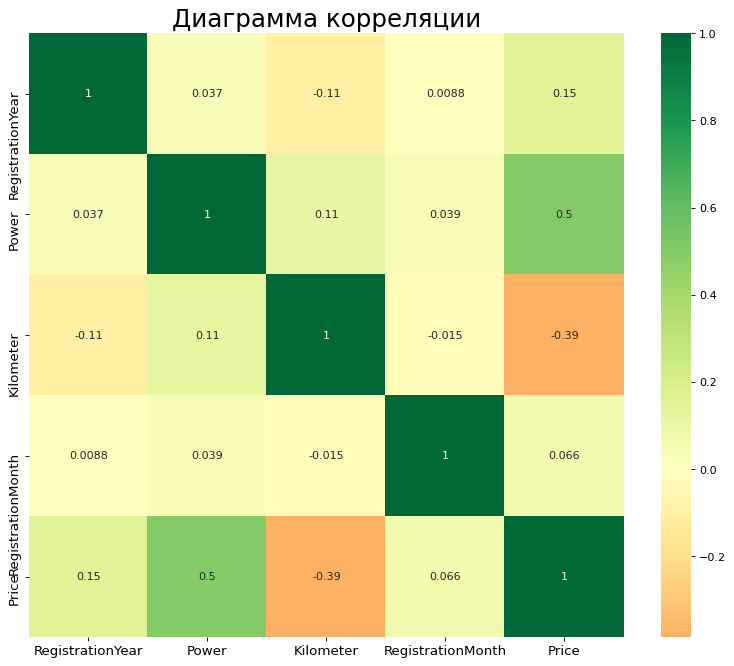

In [39]:
#Отрисуем диаграмму корреляций
ds.corr_diagram(df)

Вывод:  
Провели срез в признаке Power до 1300 лошадинных сил,так как я считаю что больше чем 1300 лс не бывает  
Заменили пустые значения в столбцах model, brand, на имеющиеся значения с похожими значениями.  
Удалили дубликаты и пустые значения (подготовили датасет)  
Перевели категориальные данные в номинальные с помощью LabelEncoder  
Провели стандартизацию  

## Обучение моделей

Изучим две модели Градиентного бустинга : CatBoost, LightGBM и Линейную регрессию  
Проверим все три модели на дефолтных параметрах без какого-либо тюнинга модели и посмотрим какие результаты они нам покажут.  
сохраним все результаты для дальнейшего анализа  

In [40]:
categorical = ['Brand', 'VehicleType','Gearbox','FuelType', 'Kilometer']

In [41]:
# Опредлим признаки и целевой признак 
X = df.drop(['Price'], axis=1)
y = df['Price']

#разделим датасет на обучающую и тестовую выборку размеров 70 на 30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=17)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=17)

#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X_train.shape[0], X_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 188643 объектов, 9 признаков
Размер тестовой выборки: 40424 объектов, 9 признаков


In [42]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe.fit(X_train[categorical])
X_train[
    ohe.get_feature_names_out()
] = ohe.transform(X_train[categorical])
X_valid[
    ohe.get_feature_names_out()
] = ohe.transform(X_valid[categorical])
X_test[
    ohe.get_feature_names_out()
] = ohe.transform(X_test[categorical])

# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train = X_train.drop(categorical, axis=1)
X_test = X_test.drop(categorical, axis=1)
X_valid = X_valid.drop(categorical, axis=1)

In [43]:
#Стандартизируем признаки с помощью StandardScaler
scaler = StandardScaler()
numeric = ['RegistrationYear','Power']
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])

In [44]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[['Model']] = encoder.fit_transform(X_train[['Model']])
X_test[['Model']] = encoder.transform(X_test[['Model']])
X_valid[['Model']] = encoder.transform(X_valid[['Model']])

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188643 entries, 214857 to 79113
Data columns (total 68 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Model                    188643 non-null  float64
 1   RegistrationYear         188643 non-null  float64
 2   Power                    188643 non-null  float64
 3   RegistrationMonth        188643 non-null  int64  
 4   Brand_audi               188643 non-null  float64
 5   Brand_bmw                188643 non-null  float64
 6   Brand_chevrolet          188643 non-null  float64
 7   Brand_chrysler           188643 non-null  float64
 8   Brand_citroen            188643 non-null  float64
 9   Brand_dacia              188643 non-null  float64
 10  Brand_daewoo             188643 non-null  float64
 11  Brand_daihatsu           188643 non-null  float64
 12  Brand_fiat               188643 non-null  float64
 13  Brand_ford               188643 non-null  float64
 14  

In [46]:
# label_encode = LabelEncoder()
# columns_for_convert = list(df.select_dtypes(include='object').columns)
# for column in columns_for_convert:
#     label_encode.fit(df[column].astype('str'))
#     X_train[column] = label_encode.transform(X_train[column].astype('str'))
#     X_test[column] = label_encode.transform(X_test[column].astype('str'))

In [47]:
X_train.head()

,Model,RegistrationYear,Power,RegistrationMonth,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,...,Kilometer_30000,Kilometer_40000,Kilometer_50000,Kilometer_60000,Kilometer_70000,Kilometer_80000,Kilometer_90000,Kilometer_100000,Kilometer_125000,Kilometer_150000
214857,29.0,0.037974,0.210202,3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18069,116.0,0.540211,1.747057,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53209,116.0,-0.527043,-0.577436,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111219,75.0,0.037974,-0.865596,10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17379,42.0,-0.024806,-0.692700,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
#Приведем категориальные признаки к формату category
categorical = ['Model', 'Brand', 'VehicleType','Gearbox','FuelType', 'Kilometer']
df_with_categorical_features[categorical] = df_with_categorical_features[categorical].astype('category')

In [49]:
X_ = df_with_categorical_features.drop(['Price'],axis=1)
y_ = df_with_categorical_features['Price']

X__train, X__test, y__train, y__test = train_test_split(X_, y_, test_size=0.3, random_state=17)
X__test, X__valid, y__test, y__valid = train_test_split(X__test, y__test, test_size=0.4, random_state=17)
#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки с категориальными данными: {} объектов, {} признаков'.format(X__train.shape[0], X__train.shape[1]))
print('Размер тестовой выборки с категориальными данными: {} объектов, {} признаков'.format(X__test.shape[0], X__test.shape[1]))

Размер обучающей выборки с категориальными данными: 188643 объектов, 9 признаков
Размер тестовой выборки с категориальными данными: 48508 объектов, 9 признаков


In [50]:
df_with_categorical_features.sample(7)

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,RegistrationMonth,Price
127895,nissan,micra,small,2000,manual,57,gasoline,150000,1,1200
347135,ford,fiesta,small,2006,manual,60,petrol,125000,4,3499
35123,volvo,xc_reihe,sedan,2011,manual,160,gasoline,150000,11,6500
285484,bmw,3er,sedan,2001,manual,116,petrol,150000,7,2000
200847,opel,corsa,small,2000,manual,65,petrol,150000,5,850
161270,renault,twingo,small,1997,auto,58,petrol,70000,5,1150
148474,opel,astra,wagon,2010,manual,110,gasoline,150000,3,4500


### CatBoost

In [51]:
#вызовем CatBoost с нашими параметрами
model_cbr = CatBoostRegressor(cat_features=categorical)

In [52]:
# from catboost import cv

In [53]:
# params = {'loss_function' : "RMSE",
#            'eval_metric' : "RMSE",
#            'learning_rate': 0.01,
#            'iterations': 1000,
#            'random_seed': 42,
#            'od_type': "Iter",
#            'depth': 10,
#            'early_stopping_rounds' : 50}

In [54]:
# from catboost import Pool

In [55]:
# cv_data = cv(
#     params=params,
#     pool=Pool(X__train, label=y__train, cat_features=categorical),
#     fold_count=5, # Разбивка выборки на 5 кусочков
#     shuffle=True, # Перемешаем наши данные
#     partition_random_seed=0,
#     plot=True, # Никуда без визуализатора
#     stratified=True, 
#     verbose=False
# )

In [56]:
# Добились 1663 на кросс валидации

In [57]:
%%time
start = time.time()
model_cbr.fit(X__train, y__train, eval_set=(X__valid, y__valid), verbose=200);
end = time.time()
catboost_time = end - start

Learning rate set to 0.115923
0:	learn: 4248.6696373	test: 4247.4522187	best: 4247.4522187 (0)	total: 337ms	remaining: 5m 36s
200:	learn: 1720.2358517	test: 1722.4890886	best: 1722.4890886 (200)	total: 34.9s	remaining: 2m 18s
400:	learn: 1663.5289108	test: 1680.5847909	best: 1680.5847909 (400)	total: 1m 8s	remaining: 1m 42s
600:	learn: 1629.1894301	test: 1661.8672092	best: 1661.8302083 (599)	total: 1m 41s	remaining: 1m 7s
800:	learn: 1605.0746886	test: 1651.2055003	best: 1651.2014754 (799)	total: 2m 18s	remaining: 34.3s
999:	learn: 1586.0873503	test: 1645.0805997	best: 1645.0805997 (999)	total: 2m 52s	remaining: 0us

bestTest = 1645.0806
bestIteration = 999

CPU times: user 2min 53s, sys: 887 ms, total: 2min 54s
Wall time: 2min 55s


In [58]:
#Посмотрим какую среднюю квадратичную абсолютную ошибку мы получили в предсказаниях.
start = time.time()
predictions = model_cbr.predict(X__valid)
end = time.time()
catboost_time_predicting = end - start
print('RMSE=',ds.rmse(predictions,y__valid))
rmse_list = []
rmse_list.append(ds.rmse(predictions,y__valid))
time_list = []
predicting_time = []
time_list.append(catboost_time)
predicting_time.append(catboost_time_predicting)

RMSE= 1645.0805997076789


### LightGBM

In [59]:
gbm = lgb.LGBMRegressor()

In [60]:
# dftrainLGB = lgb.Dataset(X__train, label=y__train, categorical_feature = categorical)

In [61]:
# params = {'objective': 'regression'}

In [62]:
# cv_results = lgb.cv(
#         params,
#         dftrainLGB,
#         num_boost_round=500,
#         nfold=5,
#         metrics='mse',
#       #  early_stopping_rounds=500,
#         #force_col_wise=True,
#         # This is what I added
#         stratified=False
#         )

In [63]:
# params = {
#     'learning_rate': 0.2,
#     'application': 'binary',
#     'num_boost_round': 100,
#     'nfold': 5,
#     'num_leaves': 31,
#     'verbosity': -1,
#     'metric': 'auc',
#     'data_random_seed': 2,
#     'bagging_fraction': 0.8,
#     'feature_fraction': 0.6,
#     'nthread': 4,
#     'lambda_l1': 1,
#     'lambda_l2': 1,
#     'early_stopping_rounds': 40,

In [64]:
%%time
start = time.time()
gbm.fit(X__train, y__train, eval_set=[(X__valid, y__valid)], eval_metric='rmse', categorical_feature=categorical)
#gbm.fit(X__train, y__train, categorical_feature='auto')
end = time.time()
lightgbm_time = end - start

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Kilometer', 'Model', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 4253.26	valid_0's l2: 1.80902e+07
[2]	valid_0's rmse: 3958.26	valid_0's l2: 1.56678e+07
[3]	valid_0's rmse: 3699.43	valid_0's l2: 1.36858e+07
[4]	valid_0's rmse: 3471.76	valid_0's l2: 1.20531e+07
[5]	valid_0's rmse: 3266.52	valid_0's l2: 1.06702e+07
[6]	valid_0's rmse: 3087.85	valid_0's l2: 9.53482e+06
[7]	valid_0's rmse: 2919.34	valid_0's l2: 8.52256e+06
[8]	valid_0's rmse: 2780.65	valid_0's l2: 7.73199e+06
[9]	valid_0's rmse: 2651.55	valid_0's l2: 7.0307e+06
[10]	valid_0's rmse: 2543.99	valid_0's l2: 6.47187e+06
[11]	valid_0's rmse: 2445.38	valid_0's l2: 5.97988e+06
[12]	valid_0's rmse: 2357.63	valid_0's l2: 5.55843e+06
[13]	valid_0's rmse: 2283.25	valid_0's l2: 5.21323e+06
[14]	valid_0's rmse: 2216.91	valid_0's l2: 4.91467e+06
[15]	valid_0's rmse: 2159.53	valid_0's l2: 4.66359e+06
[16]	valid_0's rmse: 2109.61	valid_0's l2: 4.45047e+06
[17]	valid_0's rmse: 2066.14	valid_0's l2: 4.26893e+06
[18]	valid_0's rmse: 2026.52	valid_0's l2: 4.10678e+06
[19]	valid_0's rmse:

In [65]:
start = time.time()
predictions = gbm.predict(X__valid,num_iteration=gbm.best_iteration_)
end = time.time()
lightgbm_predicting_time = end - start
print('RMSE = ', ds.rmse(predictions, y__valid))
rmse_list.append(ds.rmse(predictions,y__valid))
predicting_time.append(lightgbm_predicting_time)
time_list.append(lightgbm_time)

RMSE =  1677.3197093912413


### LinearRegression

In [66]:
lr = LinearRegression()

In [67]:
%%time
start = time.time()
lr.fit(X_train,y_train)
end = time.time()
linear_time = end - start

CPU times: user 1.53 s, sys: 963 ms, total: 2.49 s
Wall time: 2.49 s


In [68]:
 start = time.time()
predictions = lr.predict(X_valid)
end = time.time()
linear_time_predicting_ = end - start
print(ds.rmse(predictions,y_valid))
# rmse_list.append(ds.rmse(predictions,y_train))
# time_list.append(linear_time)
# predicting_time.append(linear_time_predicting_)

3023.0491030104904


**Результаты:**

Вывод:  
Запустили все три модели со стандартными параметрами, настройками.  

Получили такие результаты :  

CatBoost : 1645 на тестовой выборке, время обучения : 3min 33s  
LightGBM : 1677 на трейне, время обучения : 6min 16s  
LinearRegression : 3023 на трейне, время обучения : 50.4 s  
Пока можем сказать, что из коробки хорошие результаты дает CatBoost, 1645 и время обучения 3min 33s. На втором месте LightGBM с результатом 1677 и временем: 6min 16s . На последнем месте Линейная регрессия с результатом 3023 на тестовой выборке и временем : 50.4 s  

Посмотрим, какие результаты покажут модели, после того как мы подберем к ним наилучшие параметры  

## Анализ моделей

- Подберем параметры для наших моделей, чтобы улучшить результаты RMSE
- Сравним время обучения каждой модели с подобранными параметрами
- Изучим результаты и сохраним для дальшейнего анализа
- Посмотрим какая модель лучше работает по времени и показывает лучший результат RMSE

### CatBoost

**используем грид серч для подбора гиперпараметров модели**

In [69]:
#вызовем CatBoost с нашими параметрами
# model_cbr = CatBoostRegressor(loss_function='RMSE', 
#                               iterations=500, 
#                               learning_rate=0.2, 
#                               thread_count=-1, 
#                               random_state=18, 
#                               max_depth=10, 
#                               l2_leaf_reg=[3.5],
#                               cat_features=categorical
#                               )
grid = {'learning_rate': [0,1, 0,2],
        'depth': [8, 10],
        'l2_leaf_reg': [3.5, 4]}

In [ ]:
%%time
start = time.time()
#model_cbr.fit(X__train, y__train, plot=True, eval_set=(X__test, y__test), verbose=200);
model = CatBoostRegressor(cat_features=categorical)
grid_search_result = model.grid_search(grid, X=X__train, y=y__train, plot=True)
end = time.time()
catboost_time = end - start

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2584.1580114	test: 2586.7112435	best: 2586.7112435 (0)	total: 410ms	remaining: 6m 49s
1:	learn: 2241.5429641	test: 2252.0800323	best: 2252.0800323 (1)	total: 782ms	remaining: 6m 30s
2:	learn: 2111.1389514	test: 2123.5493119	best: 2123.5493119 (2)	total: 1.08s	remaining: 5m 59s
3:	learn: 2048.4876500	test: 2065.7149700	best: 2065.7149700 (3)	total: 1.34s	remaining: 5m 34s
4:	learn: 2003.5502625	test: 2018.0677951	best: 2018.0677951 (4)	total: 1.79s	remaining: 5m 57s
5:	learn: 1948.6537280	test: 1963.7128079	best: 1963.7128079 (5)	total: 2.11s	remaining: 5m 49s
6:	learn: 1919.0775719	test: 1938.3439187	best: 1938.3439187 (6)	total: 2.47s	remaining: 5m 51s
7:	learn: 1902.0272547	test: 1924.9617301	best: 1924.9617301 (7)	total: 2.89s	remaining: 5m 57s
8:	learn: 1884.7402831	test: 1910.0024830	best: 1910.0024830 (8)	total: 3.16s	remaining: 5m 47s
9:	learn: 1871.0286277	test: 1895.5087518	best: 1895.5087518 (9)	total: 3.48s	remaining: 5m 44s
10:	learn: 1858.3662548	test: 1881.17174

In [ ]:
#Посмотрим какую среднюю квадратичную абсолютную ошибку мы получили в предсказаниях.
start = time.time()
predictions = model.predict(X__valid)
end = time.time()
catboost_time_predicting_ = end - start
print('RMSE=',ds.rmse(predictions,y__valid))
rmse_list.append(ds.rmse(predictions,y__valid))
time_list.append(catboost_time)
predicting_time.append(catboost_time_predicting_)

### LightGBM

In [ ]:
gbm = lgb.LGBMRegressor(task='train', 
                        boosting_type='gbdt', 
                        objective='regression', 
                        metric='rmse', 
                        learning_rate=0.5, 
                        verbose=200, 
                        categorical_feature=categorical)

In [ ]:
%%time
start = time.time()
gbm.fit(X__train, y__train, eval_set=[(X__valid, y__valid)], eval_metric='rmse', early_stopping_rounds=1000)
end = time.time()
lightgbm_time = end - start

In [ ]:
start = time.time()
predictions = gbm.predict(X__valid,num_iteration=gbm.best_iteration_)
end = time.time()
lightgbm_time_predicting_ = end - start
print('RMSE = ', ds.rmse(predictions, y__valid))
rmse_list.append(ds.rmse(predictions,y__valid))
time_list.append(lightgbm_time)
predicting_time.append(lightgbm_time_predicting_)

### LinearRegression()

In [ ]:
#lr = LinearRegression()

In [ ]:
#%%time
#start = time.time()
#lr.fit(X_train,y_train)
#end = time.time()
#linear_time = end - start

In [ ]:
#start = time.time()
#predictions = lr.predict(X_test)
#end = time.time()
#linear_time_predicting_ = end - start
#print(ds.rmse(predictions,y_test))
#rmse_list.append(ds.rmse(predictions,y_test))
#time_list.append(linear_time)
#predicting_time.append(linear_time_predicting_)

**Кажется ее можно убрать, так как мы не делаем перебор параметров на регресии, плюс она не показывает какой либо эффективности** 

**Проверим качество лучшей модели на валидационной выборке**

**Поменял**

In [ ]:
start = time.time()
predictions = gbm.predict(X__test,num_iteration=gbm.best_iteration_)
end = time.time()
lightgbm_time_predicting_ = end - start
print('RMSE = ', ds.rmse(predictions, y__test))

Как видно из полученных данных:  
  
Лучший RMSE из коробки показывает CatBoost 1719
Лучшее время из коробки показал LinearRegression, но с результатов RMSE 2952  
LightGBM же показал RMSE 1794
После тюнинга моделей получили такие вот результаты:  
  
Лучший результат RMSE у LGBM 
У Catboost результат 1761 о временем обучения 223 секунд.  
LinearRegression - RMSE 2982, так как параметров у него особо нет.  

На валидационной выборке лучший результат у LGBM, он составил 1682

**Вывод:**
Мы проанализировали датасет, очистили от неинформативных признаков, провели предобработку данных

Все модели градиентного бустинга(catboost, lightgbm) из коробки показывают относительно хорошие результаты, чего не скажешь про линейную регрессию. Время обучения у всех разное от 600 сек до 0.07 секунд.
После тюнинга моделей лучший результат показал Catboost 1701 на тестовой выборке. Скорость обучения составила 628 секунд.
LightGBM - показал неплохие результаты относительно своей скорости 1751 за 6 секунд.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей